In [73]:
import numpy as np
import matplotlib.pyplot as plt

import oqupy
import oqupy.operators as op

from scipy.optimize import minimize, Bounds
from typing import List,Tuple

# --- Parameters --------------------------------------------------------------

# -- time steps --
dt = 0.05 # 0.2
num_steps = 100 # 20

# -- bath --
alpha =  0.126 #0.08
omega_cutoff = 3.04 #4
temperature =  5 * 0.1309 #1.6
pt_dkmax =60 # 40
pt_epsrel = 10**(-7) #1.0e-5

# -- initial and target state --
initial_state = op.spin_dm('x-')
target_state = op.spin_dm('x+')

# -- initial parameter guess --
x0= np.ones(num_steps)*0.0
z0 = np.ones(num_steps) * (np.pi) / (dt*num_steps)

parameter_list=[item for pair in zip(x0, z0) for item in pair] # this makes a list without the inner tuples


In [74]:
# --- Compute process tensors -------------------------------------------------
correlations = oqupy.PowerLawSD(alpha=alpha,
                                zeta=3,
                                cutoff=omega_cutoff,
                                cutoff_type='gaussian',
                                temperature=temperature)
bath = oqupy.Bath(oqupy.operators.sigma("z")/2, correlations)


pt_tempo_parameters = oqupy.TempoParameters(
    dt=dt,
    epsrel=pt_epsrel,
    dkmax=pt_dkmax)
process_tensor = oqupy.pt_tempo_compute(
    bath=bath,
    start_time=0.0,
    end_time=num_steps * dt,
    parameters=pt_tempo_parameters,
    progress_type='bar')

--> PT-TEMPO computation:
100.0%  100 of  100 [########################################] 00:00:11
Elapsed time: 11.0s


In [75]:
def hamiltonian(hx,hz):

    hx_sx = 0.5 * oqupy.operators.sigma('x') * hx
    hz_sz = 0.5 * oqupy.operators.sigma('z') * hz

    return hz_sz + hx_sx

parameterized_system=oqupy.ParameterizedSystem(hamiltonian)



In [76]:
def infidandgrad(paras):
    # take a numpy array hx0, hz0, hx1, hz1, ... over full timesteps
    # return the fidelity and gradient of the fidelity to the global target_state
    reshapedparas=[i for i in (paras.reshape((-1,2))).tolist() for j in range(2)]
    eoinscode=oqupy.state_gradient(system=parameterized_system,
        initial_state=initial_state,
        target_state=target_state.T,
        process_tensor=process_tensor,
        parameters=reshapedparas)
    fs=eoinscode['final state']
    gps=eoinscode['gradient']
    fidelity=np.sum(fs*target_state.T)
    for i in range(0,gps.shape[0],2): 
        gps[i,:]=gps[i,:]+gps[i+1,:]
    gps=gps[0::2]
    return 1-fidelity.real,(-1.0*gps.reshape((-1)).real).tolist()

In [77]:
infid,grad=infidandgrad(np.array(parameter_list))

In [78]:
lbx=[-5*np.pi for i in range(num_steps)]
lbz=[-np.pi for i in range(num_steps)]
lb_list=[item for pair in zip(lbx, lbz) for item in pair]
ubx=[5*np.pi for i in range(num_steps)]
ubz=[np.pi for i in range(num_steps)]
lb_list=[item for pair in zip(lbx, lbz) for item in pair]
ub_list=[item for pair in zip(ubx, ubz) for item in pair]

In [79]:
from scipy.optimize import minimize,Bounds

optimization_result = minimize(
                        fun=infidandgrad,
                        x0=np.array(parameter_list),
                        method='L-BFGS-B',
                        jac=True,
                        bounds=Bounds(lb_list,ub_list),
                        options = {'disp':True,'gtol': 7e-05})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.47151D-02    |proj g|=  2.09959D-03

At iterate    1    f=  7.46277D-02    |proj g|=  2.09744D-03

At iterate    2    f=  6.83182D-02    |proj g|=  3.73026D-03

At iterate    3    f=  4.30891D-02    |proj g|=  4.33271D-03

At iterate    4    f=  3.57889D-02    |proj g|=  8.21158D-04

At iterate    5    f=  3.40338D-02    |proj g|=  6.54527D-04

At iterate    6    f=  3.17831D-02    |proj g|=  5.47535D-04

At iterate    7    f=  3.13419D-02    |proj g|=  9.58095D-04

At iterate    8    f=  2.96120D-02    |proj g|=  6.05098D-04

At iterate    9    f=  2.75506D-02    |proj g|=  6.22027D-04

At iterate   10    f=  2.53184D-02    |proj g|=  4.64224D-04

At iterate   11    f=  2.39532D-02    |proj g|=  5.90902D-04

At iterate   12    f=  2.33525D-02    |proj g|=  5.71140D-04

At iterate   13    f=  2.2

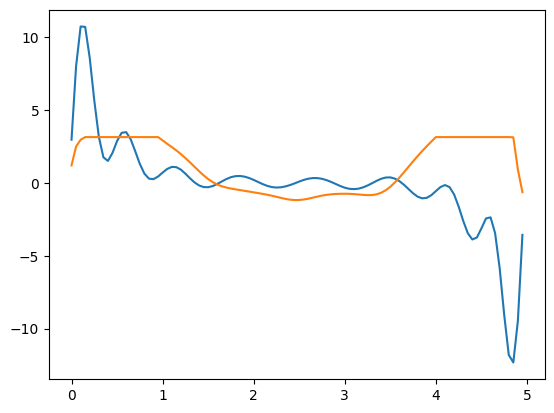

In [80]:
times=dt*np.arange(num_steps)
plt.plot(times,optimization_result['x'][0::2])
plt.plot(times,optimization_result['x'][1::2])